In [116]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn import metrics


In [2]:
wb        = load_workbook('../Data/Steam game/games_analyze.xlsx', read_only=True)
sheet     = wb.active
row_count = sheet.max_row
print(f"Total rows: {row_count}")

Total rows: 111476


In [3]:
max_rows     = row_count
rows         = 20000
start_index  = 0
df_chunks    = []

first = pd.read_excel('../Data/Steam game/games_analyze.xlsx', nrows=rows, usecols='A:Q')
cols  = first.columns
start_index += (rows + 1)
df_chunks.append(first)

while start_index < max_rows:
    chunk = pd.read_excel(
        '../Data/Steam game/games_analyze.xlsx',
        skiprows=start_index,
        nrows=rows,
        header=None,
        usecols='A:Q'
    )
    
    chunk.columns = cols
    df_chunks.append(chunk)
    start_index += rows

df = pd.concat(df_chunks, ignore_index=True)
df

,Name,Estimated owners,Peak CCU,About the game,Supported languages,Required age,Price,Windows,Mac,Linux,Metacritic score,Positive,Negative,Average playtime forever,Categories,Genres,Tags
0,Galactic Bowling,0 - 20000,0,Galactic Bowling is an exaggerated and stylize...,['English'],0,19.99,True,False,False,0,6,11,0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,0 - 20000,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0.99,True,True,False,0,53,5,0,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,0 - 20000,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",0,4.99,True,False,False,0,0,0,0,Single-player,"Action,Adventure,Indie,Strategy",NaN
3,Henosisâ„¢,0 - 20000,0,HENOSISâ„¢ is a mysterious 2D Platform Puzzler...,"['English', 'French', 'Italian', 'German', 'Sp...",0,5.99,True,True,True,0,3,0,0,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,0 - 20000,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",0,0.0,True,True,False,0,50,8,0,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111470,Paragon Of Time,0 - 20000,0,"You stand at the edge of time, trying to save ...",['English'],0,2.99,True,False,False,0,5,0,0,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111471,A Few Days With : Hazel,0 - 20000,0,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",0,2.69,True,False,False,0,0,0,0,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",NaN
111472,MosGhost,0 - 20000,0,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",0,7.99,True,False,False,0,24,12,0,"Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso..."
111473,AccuBow VR,0 - 0,0,AccuBow VR: Master Realistic Archery in Immers...,['English'],0,0,True,False,False,0,0,0,0,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",NaN


In [4]:
first.columns

Index(['Name', 'Estimated owners', 'Peak CCU', 'About the game',
       'Supported languages', 'Required age', 'Price', 'Windows', 'Mac',
       'Linux', 'Metacritic score', 'Positive', 'Negative',
       'Average playtime forever', 'Categories', 'Genres', 'Tags'],
      dtype='object')

In [204]:
data = df.copy()

# Filter games with Strategy Genre
data = data[data['Genres'].str.contains('Strategy', case=False, na=False)].reset_index(drop=True)
data.shape

# Remove unused columns
data = data.drop(columns=['Categories', 'Genres', 'Tags'])

def get_middle_value(range_str):
  start, end = map(int, range_str.split(' - '))
  return int((start + end) / 2);

# Update Estimated owners to its median value
data['Estimated owners'] = data['Estimated owners'].dropna().apply(get_middle_value)

# Update about game to its word count
data['About the game'] = data['About the game'].fillna('').astype(str).apply(
    lambda x: len(x.split())
)

# Update 'Supported languages' to its count
data['Supported languages'] = data['Supported languages'].dropna().astype(str).apply(
    lambda x: len(x.split(','))
)

data.dropna(axis=1)
data

,Name,Estimated owners,Peak CCU,About the game,Supported languages,Required age,Price,Windows,Mac,Linux,Metacritic score,Positive,Negative,Average playtime forever
0,Jolt Project,10000,0,111,2,0,4.99,True,False,False,0,0,0,0
1,Wartune Reborn,75000,68,293,1,0,0.0,True,False,False,0,87,49,0
2,TD Worlds,10000,3,129,3,0,10.99,True,False,False,0,21,7,0
3,MazM: Jekyll and Hyde,10000,1,168,10,0,14.99,True,False,False,0,76,6,0
4,Cthulhu Realms,75000,0,372,1,0,0.0,True,True,False,0,147,58,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20206,Cyber-ART,0,0,131,103,0,0,True,False,False,0,0,0,0
20207,PlanetX,0,0,232,1,0,0,True,True,False,0,0,0,0
20208,Pax Augusta,10000,524,610,5,0,19.99,True,False,False,0,144,34,0
20209,Starry Trace,10000,0,175,4,0,1.21,True,False,False,0,1,0,0


In [205]:
columns_for_clustering = [ 'Estimated owners', 'Peak CCU', 'About the game',
       'Supported languages', 'Required age', 'Price', 'Windows', 'Mac',
       'Linux', 'Metacritic score', 'Positive', 'Negative',
       'Average playtime forever']

In [206]:
data = data[data['Name'] != 'Dota 2'].reset_index(drop=True)

Text(0, 0.5, 'Peak CCU')

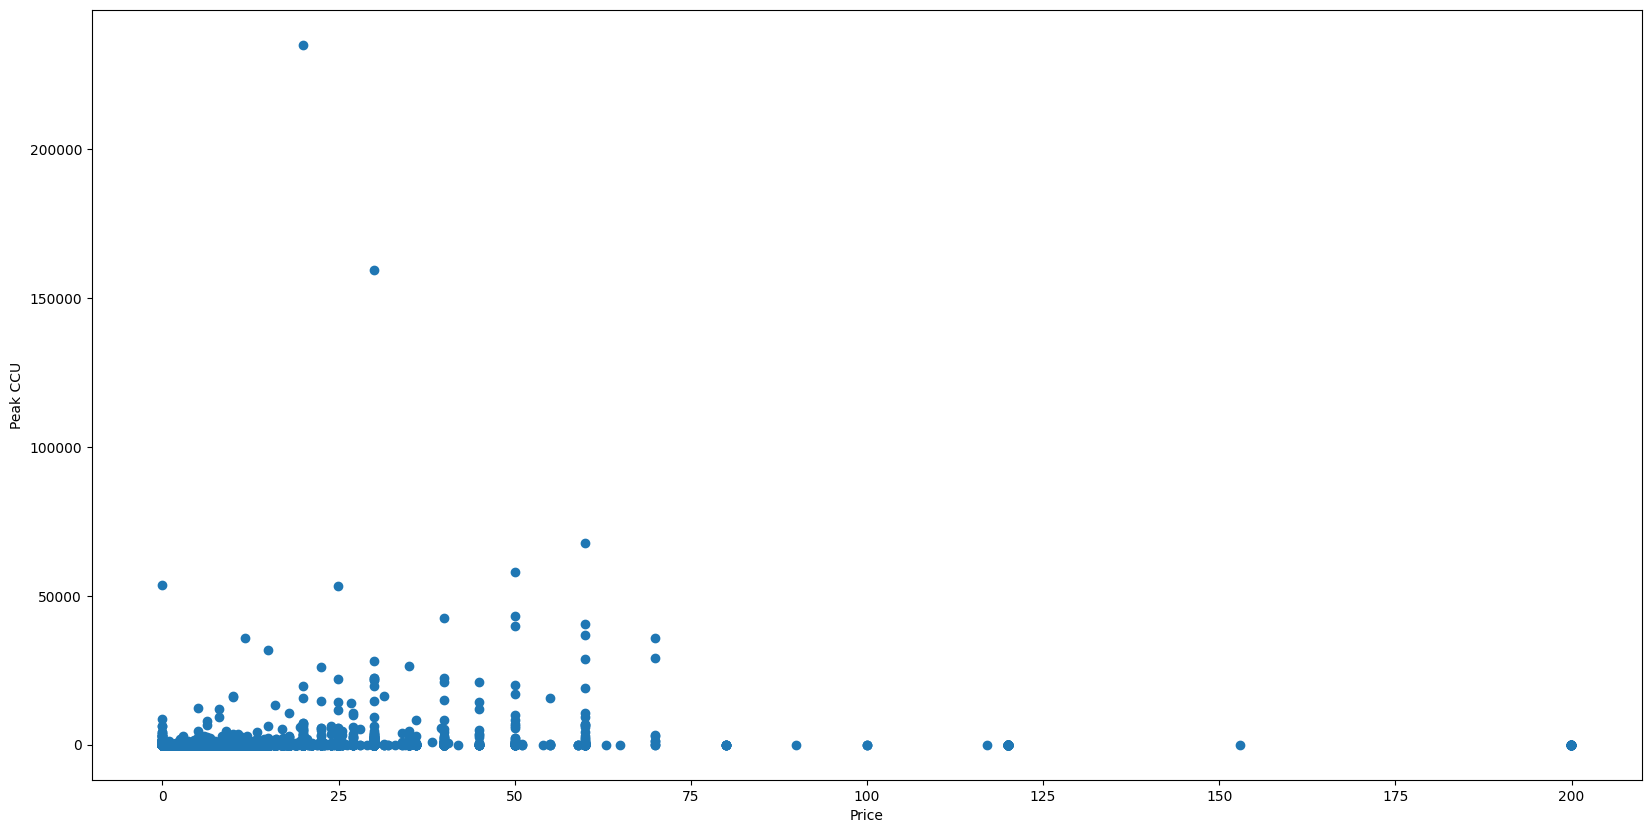

In [207]:
plt.figure(figsize=(20,10))
plt.scatter(data['Price'], data['Peak CCU'])
plt.xlabel('Price')
plt.ylabel('Peak CCU')

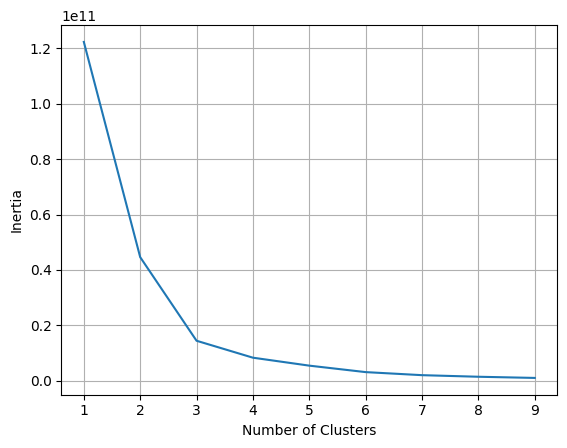

In [208]:
# Elbow method
def optimize_k_means(data, max_k):
  means    = []
  inertias = []

  for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    means.append(k)
    inertias.append(kmeans.inertia_)

  plt.plot(means, inertias)
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

optimize_k_means(data[['Price', 'Peak CCU']], 10)

In [209]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_for_clustering])

In [210]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(data_scaled)
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 36.02%


In [211]:
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=columns_for_clustering, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)



       Estimated owners  Peak CCU  About the game  Supported languages  \
PC_1          0.500417  0.230833        0.102260             0.072950   
PC_2          0.141569  0.094702        0.071519             0.394193   

      Required age     Price   Windows       Mac     Linux  Metacritic score  \
PC_1      0.101258  0.148596  0.000985  0.133406  0.130266          0.265473   
PC_2      0.013966  0.346672  0.021148  0.559428  0.569689          0.062286   

      Positive  Negative  Average playtime forever  
PC_1   0.49861  0.489478                  0.233970  
PC_2   0.15306  0.155051                  0.028435  


In [212]:
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())   
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")



*************** Most important features *************************
As per PC 1:
 Estimated owners    0.500417
Positive            0.498610
Negative            0.489478
Name: PC_1, dtype: float64


As per PC 2:
 Supported languages    0.394193
Price                  0.346672
Mac                    0.559428
Linux                  0.569689
Name: PC_2, dtype: float64

******************************************************************


Parameter: {'n_clusters': 2} Score 0.4586593151915238
Parameter: {'n_clusters': 3} Score 0.5105853318474094
Parameter: {'n_clusters': 4} Score 0.524160677296528
Parameter: {'n_clusters': 5} Score 0.4604490234119441
Parameter: {'n_clusters': 6} Score 0.5036738748429446
Parameter: {'n_clusters': 7} Score 0.461273186050688


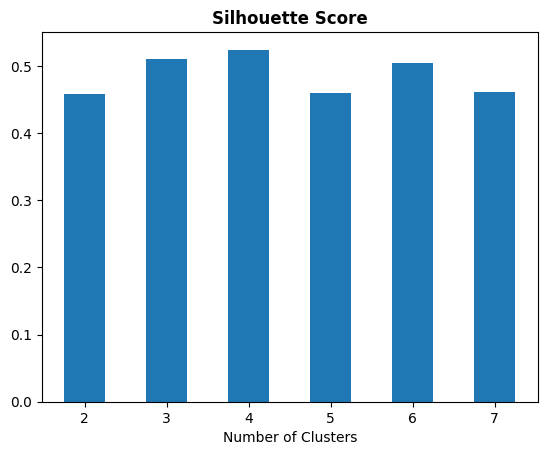

In [214]:
# Silhouette score
parameters = [2, 3, 4, 5, 6, 7]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(data_scaled)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(data_scaled, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [250]:
def process_cluster(cluster_count):
    kmeans = KMeans(n_clusters=cluster_count, random_state=35)
    kmeans.fit(data[columns_for_clustering])

    # Add cluster labels to the original DataFrame
    data['Cluster'] = kmeans.labels_


    # Plot the clusters
    plt.figure(figsize=(10, 10))
    for cluster in data['Cluster'].unique():
        plt.scatter(
            pca_2_result[data['Cluster'] == cluster, 0],
            pca_2_result[data['Cluster'] == cluster, 1],
            label=f'Cluster {cluster}'
        )

    plt.title('K-Means Clustering Visualization')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

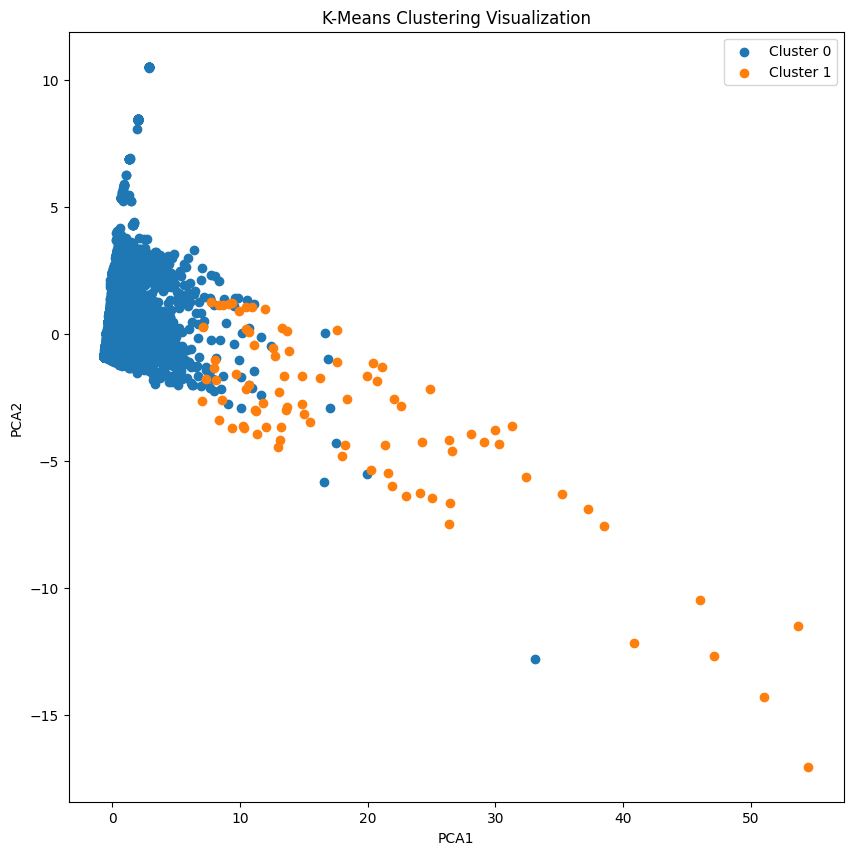

In [251]:
process_cluster(2)

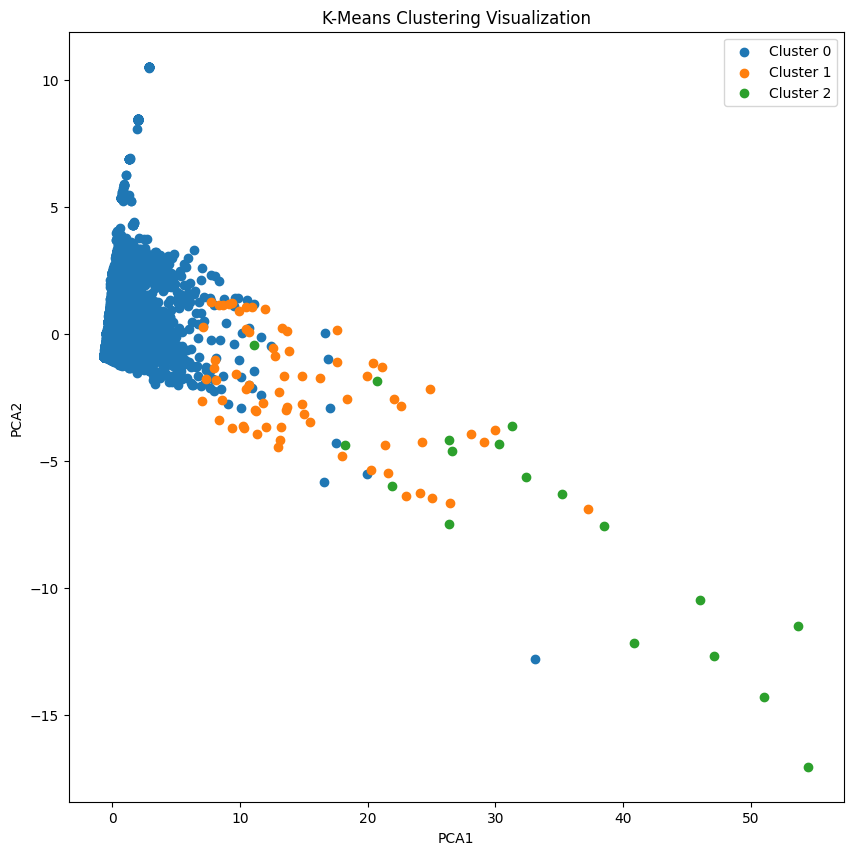

In [255]:
process_cluster(3)

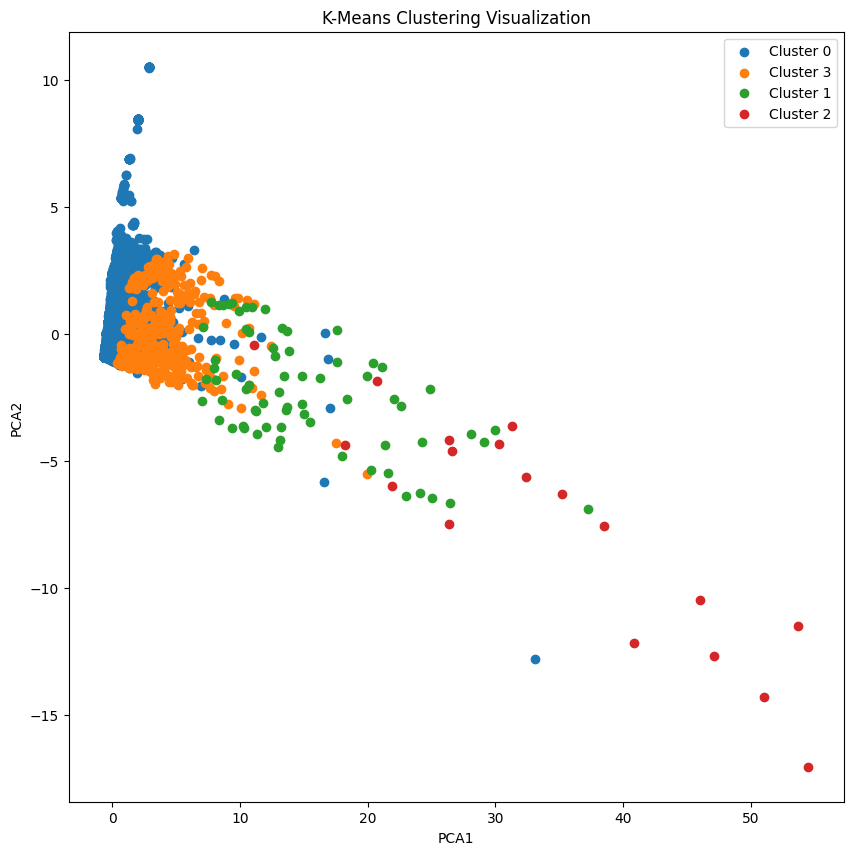

In [256]:
process_cluster(4)

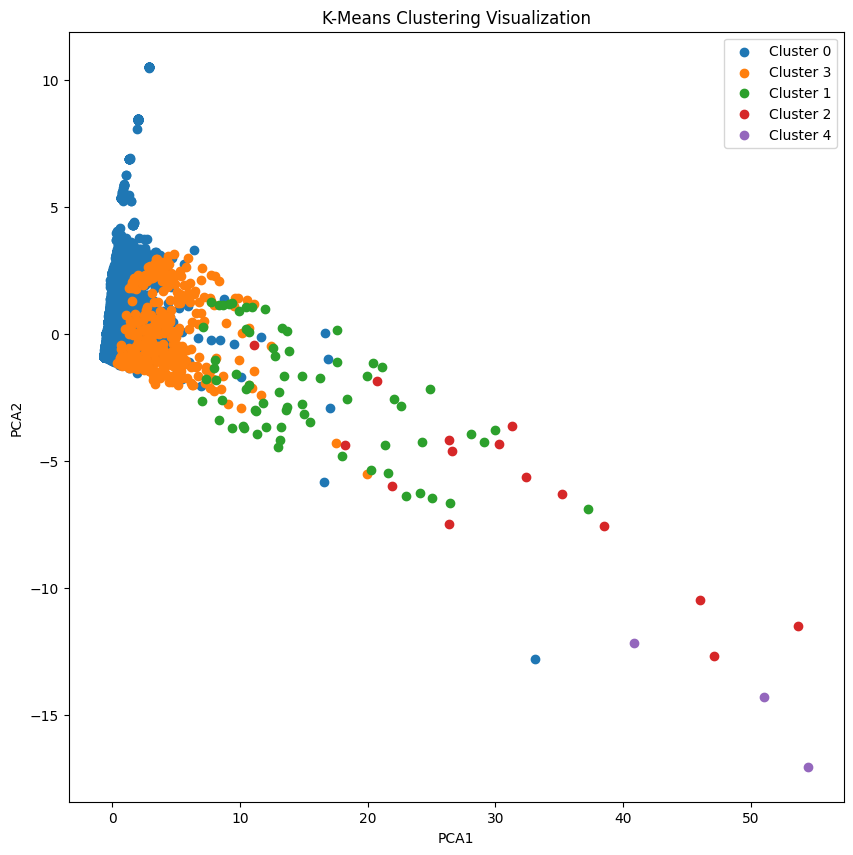

In [257]:
process_cluster(5)